## Imports

In [1]:
import copy
import numpy as np
import torch
import torch.optim as optim
from sklearn.model_selection import train_test_split
from config import config
import os
import sys
current_dir = os.getcwd()
path = "C:\\Users\\eirik\\Documents\\Master\\ISLBBNN\\islbbnn"
# path = "C:\\you\\path\\to\\islbbnn\\folder\\here"
os.chdir(path)
import plot_functions as pf
import pipeline_functions as pip_func
sys.path.append('networks')
from lrt_net import BayesianNetwork
import torch.nn.functional as F

os.chdir(current_dir) # set the working directory back to this one 

# Problem description

Problem:

$$y = x_1 + x_2 + x_1\cdot x_2 + x_1^2 + x_2^2 + 100 +\epsilon$$

where $\epsilon \sim N(0,0.01)$. 


Can make $x_3$ dependent on $x_1$. The depedence is defined in the following way:

\begin{align*}
 x_1 &\sim Unif(-10,10) \\
 x_3 &\sim Unif(-10,10) \\
 x_3 &= \text{dep}\cdot x_1 + (1-\text{dep})\cdot x_3
\end{align*}

## Batch size and parameters

In [2]:
# define parameters
HIDDEN_LAYERS = config['n_layers'] - 2 
epochs = config['num_epochs']
post_train_epochs = config['post_train_epochs']
dim = config['hidden_dim']
num_transforms = config['num_transforms']
n_nets = config['n_nets']
n_samples = config['n_samples']
lr = config['lr']
class_problem = config["class_problem"]
non_lin = config["non_lin"]
verbose = config['verbose']
save_res = config['save_res']
patience = config['patience']
SAMPLES = 1




# Define BATCH sizes
BATCH_SIZE = int((n_samples*0.8)/100)
TEST_BATCH_SIZE = int(n_samples*0.10) # Would normally call this the "validation" part (will be used during training)
VAL_BATCH_SIZE = int(n_samples*0.10) # and this the "test" part (will be used after training)

TRAIN_SIZE = int((n_samples*0.80)/100)
TEST_SIZE = int(n_samples*0.10) # Would normally call this the "validation" part (will be used during training)
VAL_SIZE = int(n_samples*0.10) # and this the "test" part (will be used after training)

NUM_BATCHES = TRAIN_SIZE/BATCH_SIZE

print(NUM_BATCHES)

assert (TRAIN_SIZE % BATCH_SIZE) == 0
assert (TEST_SIZE % TEST_BATCH_SIZE) == 0

1.0


# Sigmoid based network

## Seperate a test set for later

In [3]:
# Get linear data, here a regression problem
y, X = pip_func.create_data_unif(n_samples, beta=[100,1,1,1,1], dep_level=0.0, classification=class_problem, non_lin=non_lin)

n, p = X.shape  # need this to get p 
print(n,p,dim)

# Split keep some of the data for validation after training
X, X_test, y, y_test = train_test_split(
    X, y, test_size=0.10, random_state=42)#, stratify=y)

test_dat = torch.tensor(np.column_stack((X_test,y_test)),dtype = torch.float32)

40000 4 10


## Train, validate and test network

In [ ]:
# select the device and initiate model

# DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "mps")
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
LOADER_KWARGS = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}

all_nets = {}
metrics_several_runs = []
metrics_median_several_runs = []
for ni in range(n_nets):
    post_train = False
    print('network', ni)
    # Initate network
    torch.manual_seed(ni+42)
    net = BayesianNetwork(dim, p, HIDDEN_LAYERS, classification=class_problem).to(DEVICE)
    alphas = pip_func.get_alphas_numpy(net)
    nr_weights = np.sum([np.prod(a.shape) for a in alphas])
    print(nr_weights)

    optimizer = optim.Adam(net.parameters(), lr=lr)
    
    all_nll = []
    all_loss = []

    # Split into training and test set
    X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=1/9, random_state=ni)#, stratify=y)
            
    train_dat = torch.tensor(np.column_stack((X_train,y_train)),dtype = torch.float32)
    val_dat = torch.tensor(np.column_stack((X_val,y_val)),dtype = torch.float32)
    
    # Train network
    counter = 0
    highest_acc = 0
    best_model = copy.deepcopy(net)
    for epoch in range(epochs + post_train_epochs):
        if verbose:
            print(epoch)
        nll, loss = pip_func.train(net, train_dat, optimizer, BATCH_SIZE, NUM_BATCHES, p, DEVICE, nr_weights, post_train=post_train)
        nll_val, loss_val, ensemble_val = pip_func.val(net, val_dat, DEVICE, verbose=verbose, reg=(not class_problem))
        if ensemble_val >= highest_acc:
            counter = 0
            highest_acc = ensemble_val
            best_model = copy.deepcopy(net)
        else:
            counter += 1
        
        all_nll.append(nll)
        all_loss.append(loss)

        if epoch == epochs-1:
            post_train = True   # Post-train --> use median model 
            for name, param in net.named_parameters():
                for i in range(HIDDEN_LAYERS+1):
                    #if f"linears{i}.lambdal" in name:
                    if f"linears.{i}.lambdal" in name:
                        param.requires_grad_(False)

        if counter >= patience:
            break
        
    all_nets[ni] = net 
    # Results
    metrics, metrics_median = pip_func.test_ensemble(all_nets[ni], test_dat, DEVICE, SAMPLES=10, reg=(not class_problem)) # Test same data 10 times to get average 
    metrics_several_runs.append(metrics)
    metrics_median_several_runs.append(metrics_median)
    pf.run_path_graph(all_nets[ni], threshold=0.5, save_path=f"path_graphs/lrt/prob/test{ni}_sigmoid", show=verbose)

if verbose:
    print(metrics)
m = np.array(metrics_several_runs)
m_median = np.array(metrics_median_several_runs)

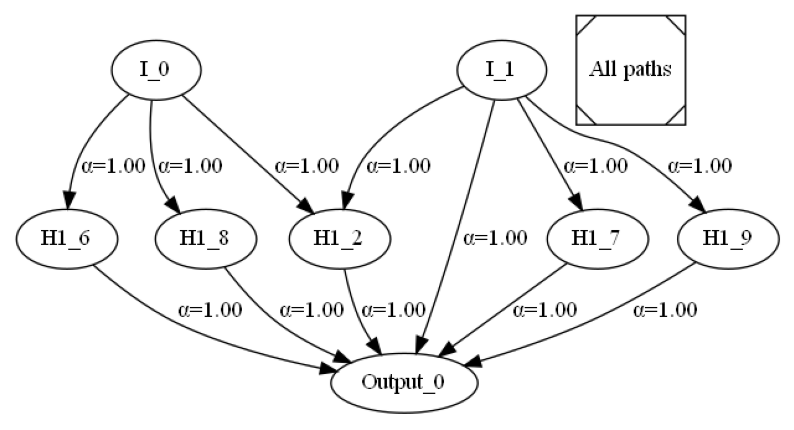

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread("path_graphs/lrt/prob/test0_sigmoid.png")
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(img)
plt.show()

After training:

* 12 weights used in median model $\rightarrow$ density of 22% compared to initialized model (54 weigths) 
* ACC of 94\% for median model
* ACC of 94\% for full model

## Function for plotting weight magnitude

In [5]:
pf.run_path_graph_weight(net, save_path="path_graphs/lrt/weight/temp_sigmoid", show=True)

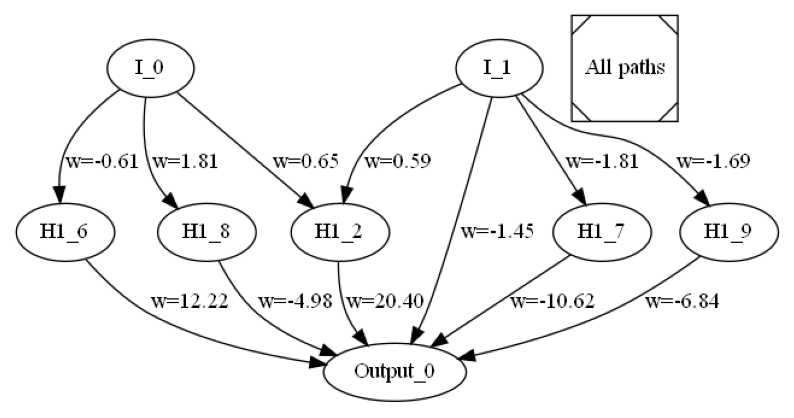

In [2]:
img = mpimg.imread("path_graphs/lrt/weight/temp_sigmoid.png")
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(img)
plt.show()

# ReLU based network

## Seperate a test set for later

In [5]:
# Get linear data
y, X = pip_func.create_data_unif(n_samples, beta=[100,1,1,1,1], dep_level=0.0, classification=class_problem, non_lin=non_lin)

n, p = X.shape  # need this to get p 
print(n,p,dim)

# Split keep some of the data for validation after training
X, X_test, y, y_test = train_test_split(
    X, y, test_size=0.10, random_state=42)#, stratify=y)

test_dat = torch.tensor(np.column_stack((X_test,y_test)),dtype = torch.float32)

40000 4 10


## Train, validate, and test model

In [ ]:
# select the device and initiate model

# DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "mps")
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
LOADER_KWARGS = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}

all_nets = {}
metrics_several_runs = []
metrics_median_several_runs = []
for ni in range(n_nets):
    post_train = False
    print('network', ni)
    # Initate network
    torch.manual_seed(ni+42)
    #---------------------------
    # DIFFERENCE IS IN act_func=F.relu part
    net = BayesianNetwork(dim, p, HIDDEN_LAYERS, classification=class_problem, act_func=F.relu).to(DEVICE)
    #---------------------------
    alphas = pip_func.get_alphas_numpy(net)
    nr_weights = np.sum([np.prod(a.shape) for a in alphas])
    print(nr_weights)

    optimizer = optim.Adam(net.parameters(), lr=lr)
    
    all_nll = []
    all_loss = []

    # Split into training and test set
    X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=1/9, random_state=ni)#, stratify=y)
            
    train_dat = torch.tensor(np.column_stack((X_train,y_train)),dtype = torch.float32)
    val_dat = torch.tensor(np.column_stack((X_val,y_val)),dtype = torch.float32)
    
    # Train network
    counter = 0
    highest_acc = 0
    best_model = copy.deepcopy(net)
    for epoch in range(epochs + post_train_epochs):
        if verbose:
            print(epoch)
        nll, loss = pip_func.train(net, train_dat, optimizer, BATCH_SIZE, NUM_BATCHES, p, DEVICE, nr_weights, post_train=post_train)
        nll_val, loss_val, ensemble_val = pip_func.val(net, val_dat, DEVICE, verbose=verbose, reg=(not class_problem))
        if ensemble_val >= highest_acc:
            counter = 0
            highest_acc = ensemble_val
            best_model = copy.deepcopy(net)
        else:
            counter += 1
        
        all_nll.append(nll)
        all_loss.append(loss)

        if epoch == epochs-1:
            post_train = True   # Post-train --> use median model 
            for name, param in net.named_parameters():
                for i in range(HIDDEN_LAYERS+1):
                    #if f"linears{i}.lambdal" in name:
                    if f"linears.{i}.lambdal" in name:
                        param.requires_grad_(False)

        if counter >= patience:
            break
        
    all_nets[ni] = net 
    # Results
    metrics, metrics_median = pip_func.test_ensemble(all_nets[ni], test_dat, DEVICE, SAMPLES=10, reg=(not class_problem)) # Test same data 10 times to get average 
    metrics_several_runs.append(metrics)
    metrics_median_several_runs.append(metrics_median)
    pf.run_path_graph(all_nets[ni], threshold=0.5, save_path=f"path_graphs/lrt/prob/test{ni}_relu", show=verbose)

if verbose:
    print(metrics)
m = np.array(metrics_several_runs)
m_median = np.array(metrics_median_several_runs)

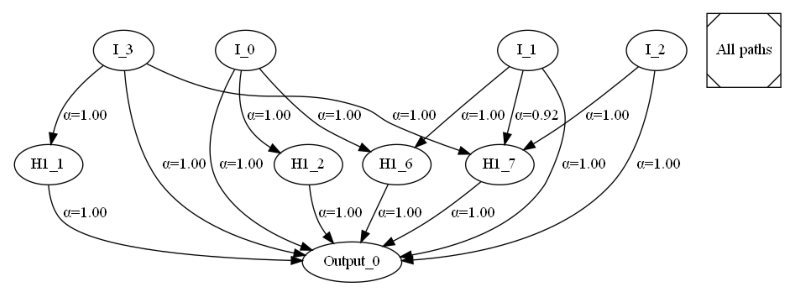

In [3]:
img = mpimg.imread("path_graphs/lrt/prob/test0_relu.png")
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(img)
plt.show()

After training:

* 13 weights used in median model $\rightarrow$ density of 24% compared to initialized model (54 weigths) 
* ACC of 90\% for median model
* ACC of 90\% for full model

## Weight graph

In [7]:
pf.run_path_graph_weight(net, save_path="path_graphs/lrt/weight/temp_relu", show=True)

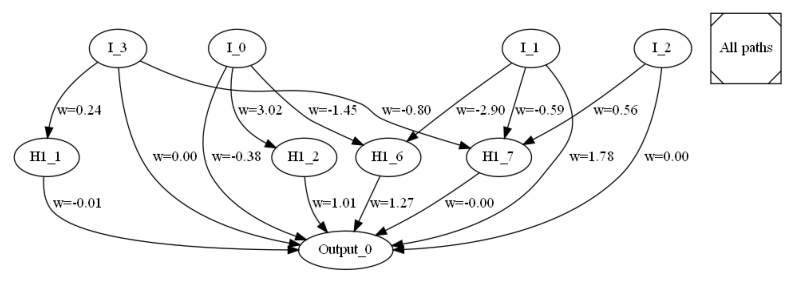

In [4]:
img = mpimg.imread("path_graphs/lrt/weight/temp_relu.png")
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(img)
plt.show()

## Local contribution

### Empirical approach

True class: 1.0


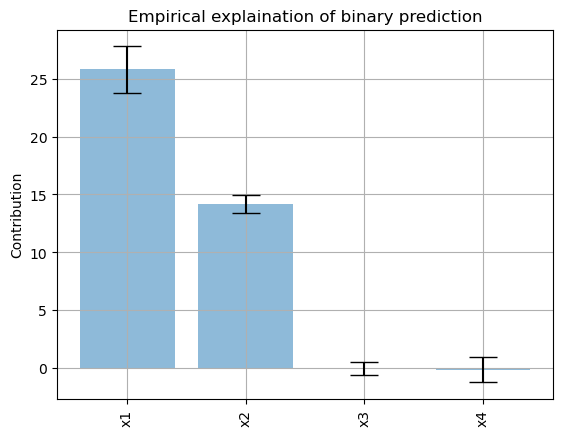

In [8]:
explain_this = train_dat[8,:-1].reshape(-1, p)
print(f"True class: {train_dat[14,-1]}")
pf.plot_local_contribution_empirical(net, explain_this, sample=True, median=True, n_samples=1_000, include_bias=False, variable_names=["x1", "x2", "x3", "x4"], class_names=["binary prediction"])

### Distribution approach

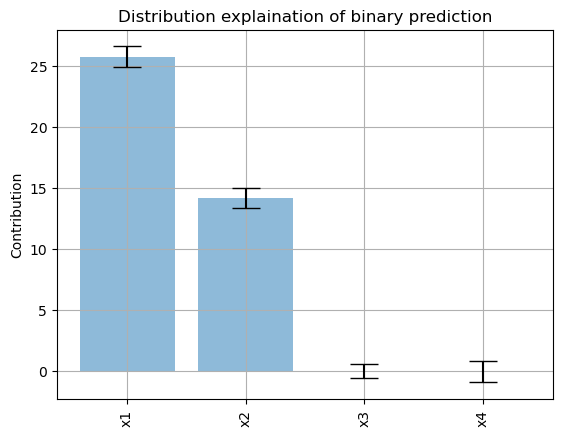

In [10]:
pf.plot_local_contribution_dist(net, explain_this, sample=False, median=True, variable_names=["x1", "x2", "x3", "x4"], class_names=["binary prediction"])